# Fraud Detection - Comparison of Different Techniques

In this notebook, I explore and experiment with different methods for anomaly detection. I plan to explore at least one method in each learning paradigm, namely, supervised, unsupervised, and semi-supervised learning. In supervised learning I will test a simple linear classifier (**logistic regression**) with the traditional technique of downsampling to handle data imbalance. In unsupervised learning, I will test **autoencoders**, and **deep one-class classification**. In semi-supervised learning, I will test a recent method called **Deep Semi-supervised Anomaly Detection** (Deep SAD) which is an extension of deep one-class classification. More details about these methods will follow. 

Note that this notebook is not meant to be an extensive research of all state-of-the-art methods in anomaly detection, nor it is meant to give a statement about the best method for fraud detection problem. My aim is to explore some different techniques to gain understanding of these methods and of the fraud detection problem in general, and also to have fun.

# Dataset Analysis

The dataset is a collection of credit card transactions for some European cardholders, where every transaction is given a label to indicate whether it was a normal or fraud transaction. The data is provided on Kaggle by the Machine Learning Group of ULB (Université Libre de Bruxelles). 

First, we load the dataset and do basic analysis to understand the data we are dealing with.

In [2]:
import numpy as np 
import pandas as pd 


df = pd.read_csv('creditcard.zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We know from the dataset providers that the features 'V1' to 'V28' are the principal components obtained after applying PCA to the original data. The 'Time' feature represents the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount (probably in Euros). The feature 'Class' is the label of the transaction with '1' for fraud and '0' for normal.

Now let's have a look at all features to see how they are distributed.

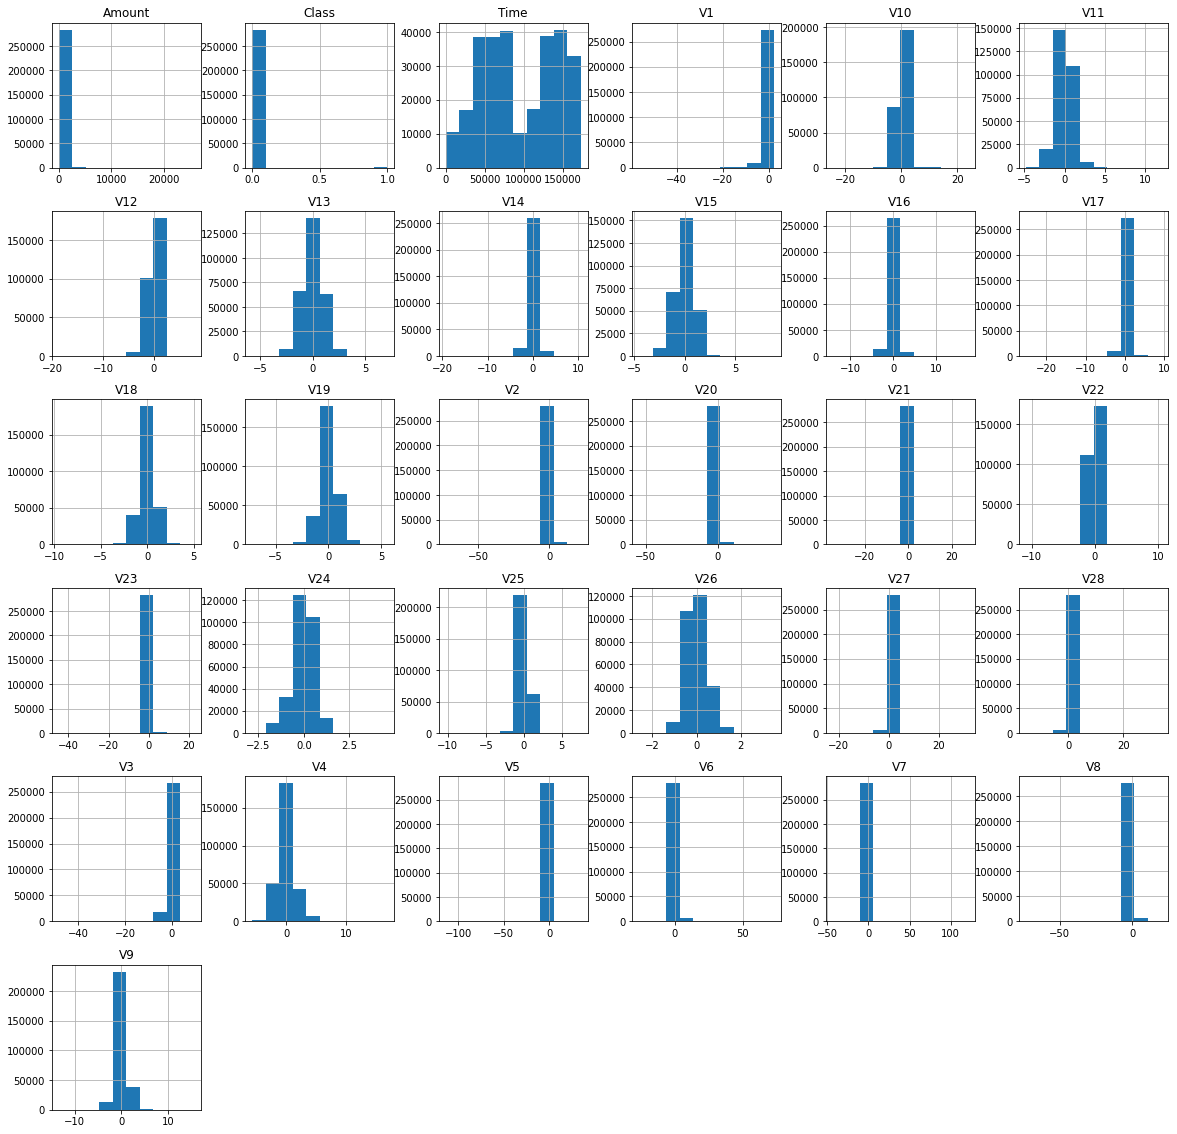

In [2]:
p = df.hist(figsize=(20,20))

We see that the features 'V1' to 'V28'  are normalized and all have mean 0. The features 'Time' and 'Amount' though are not normalized, so we normalize them manually. 

In [3]:
from sklearn.preprocessing import StandardScaler

df['amount_scaled'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['time_scaled'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)

Next, let's see more closely how the class label is distributed.

In [4]:
print('Number of fraud cases: {}, with percentage: {:.2f}%'.format(len(df[df.Class==1]), (len(df[df.Class==1])*100/len(df))))
print('Number of normal cases: {}, with percentage: {:.2f}%'.format(len(df[df.Class==0]), (len(df[df.Class==0])*100/len(df))))

Number of fraud cases: 492, with percentage: 0.17%
Number of normal cases: 284315, with percentage: 99.83%


Clearly, the dataset is highly imbalanced, which is something to be expected in this kind of problems. The way we handle this imbalance will be different in each method we use. We will come to that later.

Lastly, let's check if the dataset has any missing values before we use it for training.

In [5]:
missing_val_count_by_column = (df.isnull().sum())
num_cols_with_missing = len(missing_val_count_by_column[missing_val_count_by_column > 0])
print('Number of columns with missing values: ', num_cols_with_missing)

Number of columns with missing values:  0


Good news, we don't have any missing values. So, let's begin modeling...

#  Supervised Learning 

In this category, we will experiment with a logistic regression classifer. There are different ways for handling the imbalance in training data in supervised learning. One common and simple technique is resampling (downsampling, oversampling). In this notebook, I try downsampling. Maybe in later versions I will test oversampling as well. Another possible technique is giving higher weights for prediction errors in the anomalous class during training.

To see the effect of imbalanced data on the performance of the classifier, we will build our first model with the whole dataset as it is, and see how much it improves after balancing the data.

Before building our models, we prepare the data for usage and take out a proportion of the data for testing purposes. We will not touch the test data during the training nor use it for model selection, it will only be used for reporting the performance of the final selected model on unseen data.

In [6]:
from sklearn.model_selection import train_test_split
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
random_state=np.random.RandomState(seed)

X = df.drop('Class', axis=1)
y = df['Class']
X = X.values
y = y.values

idx_norm = y == 0
idx_out = y == 1
        
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X[idx_norm], y[idx_norm],
                                                                        test_size=0.4, random_state=random_state)
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X[idx_out], y[idx_out],
                                                                    test_size=0.4, random_state=random_state)
X_train = np.concatenate((X_train_norm, X_train_out))
y_train = np.concatenate((y_train_norm, y_train_out))

X_test = np.concatenate((X_test_norm, X_test_out))
y_test = np.concatenate((y_test_norm, y_test_out))


Now we build our unbalanced logistic regression model.

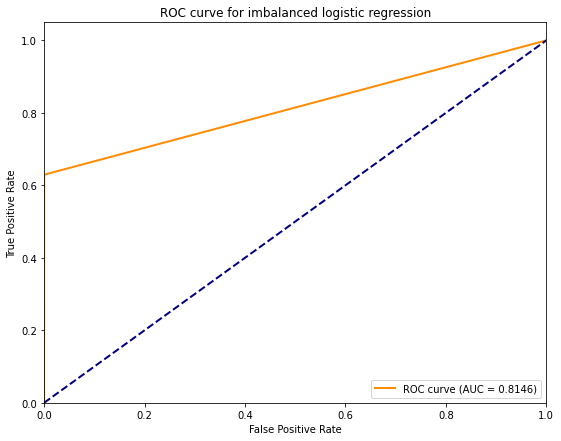

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

log_reg = LogisticRegression(penalty='l1', C=10, solver='liblinear')
log_reg.fit(X_train, y_train)

log_reg_pred = log_reg.predict(X_test)

fpr, tpr, thresold = roc_curve(y_test, log_reg_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for imbalanced logistic regression')
plt.legend(loc="lower right")

We see that, to get high recall (i.e. to detect all frauds) we will have to suffer from high false positive rate (i.e. innocent and authentic cardholders being identified as frauds). 
Let's see if balancing the data by downsampling will enhance the performance of our model. We will randomly select a subsample of the non-fraud examples so that we have equivalent examples for each class.

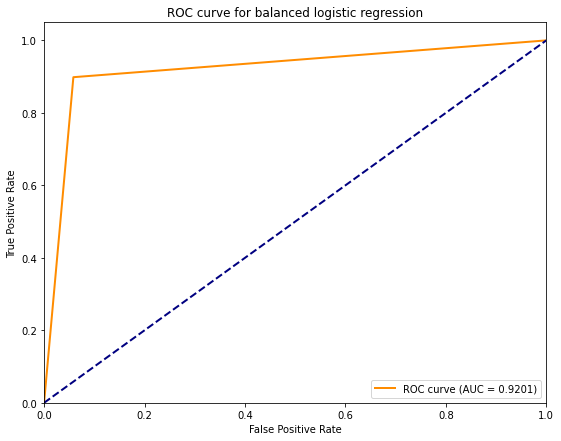

In [8]:
from numpy.random import permutation

#now we do downsampling of the normal calss data
np.random.RandomState(seed)
perm = permutation(len(X_train_norm))
X_train_norm = X_train_norm[perm]
y_train_norm = y_train_norm[perm]
X_train_norm_downsmp = X_train_norm[:len(X_train_out)]
y_train_norm_downsmp = y_train_norm[:len(X_train_out)]


X_train_downsmp = np.concatenate((X_train_norm_downsmp, X_train_out))
y_train_downsmp = np.concatenate((y_train_norm_downsmp, y_train_out))

#log_reg = LogisticRegression(penalty='l1', C=10, solver='liblinear')
log_reg.fit(X_train_downsmp, y_train_downsmp)

log_reg_pred = log_reg.predict(X_test)

fpr, tpr, thresold = roc_curve(y_test, log_reg_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for balanced logistic regression')
plt.legend(loc="lower right")

That's great! downsampling introduced a significant improvement in the performance of the model. We get now an AUC=0.9201 as compared to AUC=0.8146 with the imbalanced data. I would say that's a very good performance for such a simple linear classifier (we will see later if introducing nonlinearity would help). In future versions of this notebook I will use **cross validation** and **grid search** for selecting the best model.

# Unsupervised Learning

In this category, I will explore two methods, The first is autoencoders, and the second is deep one-class classification. Some people categorize these methods as semi-supervised since we usually use the data examples belonging to the normal class (hence we need labeled normal data). However, the main premise that these methods are built upon, is that they can work with unlabeled data even if this data is polluted with some anomalous examples since it is assumed that the majority of the data are normal and the anomalous examples are few (which is usually true). Therefore, these methods should extract the common factors of variation in the normal class and should not be greatly affected by the presence of some noisy outliers. We will put this assumption to test now and train these models with all the training set (normal + anomalous) and see how they perform.

We begin with autoencoders. The main idea, in brief, is that the autoencoder tries to learn to reconstruct the input examples as faithful as possible, and in doing so it will learn a latent representation of the data that captures the repeated patterns in this data. After training, we present a test example to the autoencoder which tries to reconstruct it. The reconstruction error (distance between the reconstructed and original example) is computed. The anomalous test example should have high reconstruction error as compared to normal examples since it should have different latent representation. 

We will build a simple autoencoder consisting of two-layers encoder and two-layers decoder.



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

input_dim = X_train.shape[1]

class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #encoder
        self.enc_layer1 = nn.Linear(input_dim,15)
        self.enc_layer2 = nn.Linear(15,10)
        #Decoder
        self.dec_layer1 = nn.Linear(10,15)
        self.dec_layer2 = nn.Linear(15,input_dim)
        
        
    def forward(self,x):
        x = F.relu(self.enc_layer1(x))
        x = F.relu(self.enc_layer2(x))
        x = F.relu(self.dec_layer1(x))
        x = F.relu(self.dec_layer2(x))
        
        return x

ae = AutoEncoder()
print(ae)

AutoEncoder(
  (enc_layer1): Linear(in_features=30, out_features=15, bias=True)
  (enc_layer2): Linear(in_features=15, out_features=10, bias=True)
  (dec_layer1): Linear(in_features=10, out_features=15, bias=True)
  (dec_layer2): Linear(in_features=15, out_features=30, bias=True)
)


Before training let's prepare the dataset in pytorch format.

In [10]:
X_train_torch = torch.from_numpy(X_train).type(torch.FloatTensor) #note that we used X_train which contains data from both classes
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_torch = torch.from_numpy(y_test)

train = TensorDataset(X_train_torch,y_train_torch)
test = TensorDataset(X_test_torch,y_test_torch)

train_dataloader = torch.utils.data.DataLoader(train,batch_size=100,shuffle=True, num_workers=3)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=50,shuffle=True, num_workers=3)

In [11]:
torch.manual_seed(seed)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

epochs = 10

#begin training
for epoch in range(epochs):
    for batch_idx, (data,target) in enumerate(train_dataloader):
        data = torch.autograd.Variable(data)
        optimizer.zero_grad()
        pred = ae(data)
        loss = loss_func(pred, data)
        loss.backward()
        optimizer.step()

Now let's evaluate the model on the test set.

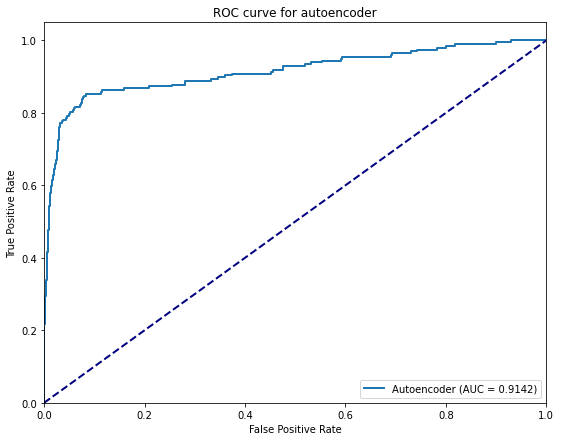

In [12]:
ae.eval()
predictions = []
for batch_idx, (data,target) in enumerate(test_dataloader):
        data = torch.autograd.Variable(data)
        pred = ae(data)
        for prediction in pred:
            predictions.append(prediction.detach().numpy())
            
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

fpr_ae, tpr_ae, thresold = roc_curve(y_test, mse)
roc_auc_ae = auc(fpr_ae, tpr_ae)

plt.figure(figsize=(9,7))
lw = 2
plt.plot(fpr_ae, tpr_ae, lw=lw, label='Autoencoder (AUC = %0.4f)' % roc_auc_ae)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for autoencoder')
plt.legend(loc="lower right")
plt.show()

That's a very good AUC measure given that the anomalous data were included in the training data for the autoencoder. Out of criousity, let's see how much it will improve if we used a clean training data consisting only of normal examples.

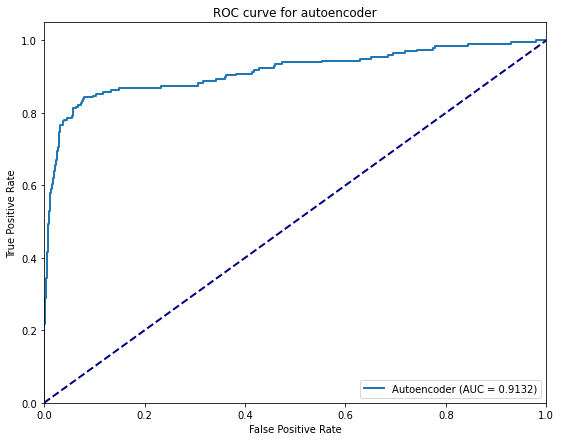

In [13]:
X_train_norm_torch = torch.from_numpy(X_train_norm).type(torch.FloatTensor)
y_train_norm_torch = torch.from_numpy(y_train_norm)

X_test_torch = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_torch = torch.from_numpy(y_test)

train = TensorDataset(X_train_norm_torch,y_train_norm_torch)
test = TensorDataset(X_test_torch,y_test_torch)

train_dataloader = torch.utils.data.DataLoader(train,batch_size=100,shuffle=True, num_workers=3)
test_dataloader = torch.utils.data.DataLoader(test,batch_size=50,shuffle=True, num_workers=3)

torch.manual_seed(seed)

ae = AutoEncoder()

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    
    for batch_idx, (data,target) in enumerate(train_dataloader):
        data = torch.autograd.Variable(data)
        optimizer.zero_grad()
        pred = ae(data)
        loss = loss_func(pred, data)
        loss.backward()
        optimizer.step()
        
        
ae.eval()
predictions = []
for batch_idx, (data,target) in enumerate(test_dataloader):
        data = torch.autograd.Variable(data)
        pred = ae(data)
        for prediction in pred:
            predictions.append(prediction.detach().numpy())
            
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
fpr_ae, tpr_ae, thresold = roc_curve(y_test, mse)
roc_auc_ae = auc(fpr_ae, tpr_ae)

plt.figure(figsize=(9,7))
lw = 2
plt.plot(fpr_ae, tpr_ae, lw=lw, label='Autoencoder (AUC = %0.4f)' % roc_auc_ae)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for autoencoder')
plt.legend(loc="lower right")
plt.show()

The AUC is almost the same. This means that the autoencoder is very robust to the presence of anomalous data and can be trained efficiently with noisy unlabeled data.

Optimizing for the autoencoder hyperparameters will possibly improve the above results. Also, there are other variants of the autoencoder which are used in anomaly detection that I might try in the future. Examples are [variational autoencoders](https://www.semanticscholar.org/paper/Variational-Autoencoder-based-Anomaly-Detection-An-Cho/061146b1d7938d7a8dae70e3531a00fceb3c78e8), and [autoencoder ensembles](https://saketsathe.net/downloads/autoencode.pdf).

Next, we evaluate a method that belong to the category of one-class classification. The method is called **Deep SVDD**. It was introduced by [Ruff et al. 2018](http://proceedings.mlr.press/v80/ruff18a/ruff18a.pdf). The main idea of Deep SVDD is to transform the input points through a multilayer neural network into an enclosing hypersphere with minimal radius. Assuming the normal examples are similar, this projection of the input points extracts the common factors of variation in the normal examples, which leads to the anomalous points being projected away from the center of the sphere since they don't share the common factors of variation as the normal points. The training objective of Deep SVDD is 

$$\min_W \frac{1}{n} \sum_{i=1}^{n} \left \| \phi(x_i;W) -c \right \|^2,$$

where $\phi(x_i;W)$ is the neural network function (parameterized by $W$) applied to example $x_i$, and $c$ is the center of the hypersphere. There is an additional regularization term in the objective but I omitted it here for simplicity.

To evaluate the anomalousness of a test example $x$, Deep SVDD uses the distance from $\phi(x;W)$ and the center of the hypersphere as an anomaly score as follows:

$$s(x) = \left \| \phi(x;W) -c \right \| .$$

The source code of Deep SVDD is publicly available [here](https://github.com/lukasruff/Deep-SVDD). To save you the long training time I present here the results that I obtained. Most hyperparameter choices are left to their default values in the original code. 

Below I show the ROC plot for Deep SVDD trained on mixed data (normal + anomalous).

![](images/roc_oc_mixed.png)

The AUC is less than that of the autoencoder. Let's see how Deep SVDD performs when trained on clean data (normal examples only).

![](images/roc_oc_clean.png)

The AUC is improved significantly when trained on normal data alone. It seems that Deep SVDD is trying hard to fit all the training examples into the enclosing hypersphere. Or maybe if I tried to optimize the hyperparameters I would get better results than those. That could be a possible future work as well.

# Semi-Supervised Learning

The method we are going to explore in this category is called **Deep SAD** (short for Deep Semi-supervised Anomaly Detection). It was proposed by [Ruff et al. 2019](https://arxiv.org/pdf/1906.02694.pdf). It is an extension of the previously discussed Deep SVDD where it incorporates the anomalous examples in the training such that the anomalous examples are projected far away from the center of the hypersphere. Assume we have $n$ unlabeled examples and $m$ labeled examples with the labels being -1 for anomalous and +1 for normal. The objective of Deep SAD is as follows:

$$\min_W \frac{1}{n+m} \sum_{i=1}^{n} \left \| \phi(x_i;W) -c \right \|^2 + \frac{\eta}{n+m} \sum_{j=1}^{m}\left ( \left \| \phi(\tilde{x}_j;W) -c \right \|^2  \right )^{\tilde{y}_j},$$

where $\eta$ is a hyperparameter that controls the balance between the labeled and unlabeled data. From the above objective we see that when $\tilde{y}_j=1$ (i.e. normal example) the optimizer minimizes the distance between the projected example and the center of the hypersphere, on the other hand, when  $\tilde{y}_j=-1$ (i.e. anomalous example) the optimizer maximizes the distance between the projected example and the center of the hypersphere. As a result, we get a better separation between the normal and anomalous examples in the latent projection space.

The source code of Deep SAD is publicly available [here](https://github.com/lukasruff/Deep-SAD-PyTorch). As in the previous section, I present here the results immediately to save you the training time. Most of the hyperparameters are left as it is in the original code. Now let's have a look at the performance of Deep SAD.

![roc.png](images/roc_sad.png)

Well, as you can see, Deep SAD has much better performance than all previous methods. It has a near perfect AUC of 0.9881. In my opinion, the basic idea of Deep SAD is the most elegant of all the previously explored methods.

# Summary

In this notebook, we tested four main methods, logistic regression, autoencoders, deep one-class classification, and semi-supervised deep one-class classification. We saw how the unbalanced data can affect the model performance, and we saw different techniques for handling and working around this problem. Below is a graph that combines the ROC curves of all 4 methods in one plot. 

![roc.png](images/roc_all.png)

Note that for the logistic regression model I only plotted the one trained on downsampled data, and for autoencoder and Deep SVDD I only plot the models trained on normal class alone (just to simplify the plot, otherwise it would be a mess).

One last word before you leave. Remember that these numbers and this ranking of the methods do not mean that this is necessarily the real ranking of these methods in general. This is only the performance of these methods on this dataset. And these numbers could even go higher if we did hyperparameter optimization for each method. But overall, we got a rough idea of how these methods perform and how they tackle the anomaly detection problem.